In [0]:
# READ easy positive
# https://www.groundai.com/project/improved-embeddings-with-easy-positive-triplet-mining/1

#------------------------------imports EmbeddingNet------------------#
import torch 
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import torchvision

import numpy as np
from numpy import mean
import torchvision.transforms as transforms
#------------------------------imports Sampler-----------------------#
from torch.utils.data.sampler import Sampler
from collections import defaultdict
import random
import torch.nn.functional as F

#------------------------------imports Dataset-----------------------#
from PIL import Image
import PIL.ImageOps

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import torchvision.datasets as dset

from torch.utils.data import Dataset

import os
import matplotlib.pyplot as plt
import numpy as np


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class EmbeddingNet(nn.Module):
  def __init__(self,backbone=None):
    super(EmbeddingNet,self).__init__()
    if backbone is None:
      backbone = models.resnet18(num_classes=128)
    self.backbone = backbone
  def forward(self,x):
    x=self.backbone(x)
    x= nn.functional.normalize(x,dim=1)
    return x


In [0]:
def create_groups(groups,k):
  group_samples = defaultdict(list)
  for sample_idx, group_idx in enumerate(groups):
    group_samples[group_idx].append(sample_idx) #might need to leave this as it is or swap
  keys_to_remove =[]
  for key in group_samples:
    if len(group_samples[key])<k:
      keys_to_remove.append(key)
      continue
  for key in keys_to_remove:
    group_samples.pop(key)
  return group_samples

In [0]:
class PKSampler(Sampler):
  def __init__(self,groups,p,k):
    self.p = p
    self.k= k
    self.groups = create_groups(groups,self.k)
    
    assert len(self.groups)>=p
  def __iter__(self):
    #shuffle samples within groups
    for key in self.groups:
      groups_samples_remaining={}
    for key in self.groups:
      groups_samples_remaining[key] = len(self.groups[key])
    
    while len(groups_samples_remaining)>self.p:
      groups_ids = list(groups_samples_remaining.keys())
      selected_groups_idxs = torch.multinomial(torch.ones(len(groups_ids)),self.p).tolist()

      for i in selected_groups_idxs:
        group_id = groups_ids[i]
        group = self.groups[group_id]
        for _ in range(self.k):
          sample_idx = len(group) - groups_samples_remaining[group_id]
          yield sample_idx
          groups_samples_remaining[group_id]-=1
        if groups_samples_remaining[group_id]<self.k:
          groups_samples_remaining.pop(group_id)

In [0]:
class TripletMarginLoss(nn.Module):
  def __init__(self,margin=0.1,p=2.,mining='batch_hard'):
    super(TripletMarginLoss,self).__init__()
    self.margin =margin
    self.p = p
    self.mining= mining
    if mining == 'batch_all':
      self.loss_fn = batch_all_triplet_loss
    if mining =='batch_hard':
      self.loss_fn = batch_hard_triplet_loss
    
  def forward(self,embeddings,labels):
    return self.loss_fn(labels,embeddings,self.margin, self.p)

def batch_hard_triplet_loss(labels,embeddings,margin,p):
  pairwise_dist = torch.cdist(embeddings,embeddings,p=p)

  mask_anchor_positive = _get_anchor_positive_triplet_mask(labels).float()
  anchor_positive_dist = mask_anchor_positive * pairwise_dist

  hardest_positive_dist,_ = anchor_positive_dist.max(1,keepdim=True)

  mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()

  max_anchor_negative_dist,_=pairwise_dist.max(1,keepdim=True)
  anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0-mask_anchor_negative)

  hardest_negative_dist, _ = anchor_negative_dist.min(1, keepdim=True)

  triplet_loss = hardest_positive_dist - hardest_negative_dist + margin
  triplet_loss[triplet_loss<0]=0
  
  triplet_loss = triplet_loss.mean()

  return triplet_loss, -1

def batch_all_triplet_loss(labels,embeddings,margin,p):
  pairwise_dist = torch.cdist(embeddings,embeddings,p=p)

  anchor_positive_dist = pairwise_dist.unsqueeze(2)
  anchor_negative_dist = pairwise_dist.unsqueeze(1)

  triplet_loss= anchor_positive_dist - anchor_negative_dist + margin

  mask = _get_triplet_mask(labels)
  triplet_loss = mask.float() * triplet_loss

  triplet_loss[triplet_loss<0] =0
  valid_triplets = triplet_loss[triplet_loss>1e-16]
  num_positive_triplets = valid_triplets.size(0)
  num_valid_triplets = mask.sum()

  fraction_positive_triplets = num_positive_triplets/ (num_valid_triplets.float()+1e-16)

  triplet_loss = triplet_loss.sum()/(num_positive_triplets+1e-16)

  return triplet_loss, fraction_positive_triplets

def _get_triplet_mask(labels):
  indices_equal = torch.eye(labels.size(0),dtype=torch.bool,device= labels.device)
  indices_not_equal = ~indices_equal

  i_not_equal_j = indices_not_equal.unsqueeze(2)
  i_not_equal_k = indices_not_equal.unsqueeze(1)
  j_not_equal_k = indices_not_equal.unsqueeze(0)

  distinct_indices = (i_not_equal_j & i_not_equal_k) & j_not_equal_k
  label_equal = labels.unsqueeze(0)==labels.unsqueeze(1)

  i_equal_j = label_equal.unsqueeze(2)
  i_equal_k= label_equal.unsqueeze(1)
  valid_labels = ~i_equal_k & i_equal_j

  return valid_labels & distinct_indices

def _get_anchor_positive_triplet_mask(labels):
  indices_equal = torch.eye(labels.size(0),dtype=torch.bool,device=labels.device)
  indices_not_equal  = ~indices_equal

  labels_equal = labels.unsqueeze(0)==labels.unsqueeze(1)

  return labels_equal & indices_not_equal

def _get_anchor_negative_triplet_mask(labels):
  return labels.unsqueeze(0)!=labels.unsqueeze(1)

In [0]:
def show_plot_two(x_axis_array1,y_axis_array1,y_axis_array2,graph_1_lab="gr1",graph_2_lab="gr2",title="set title",x_label="epoch",y_label="loss"):
  plt.plot(x_axis_array1,y_axis_array1,label=graph_1_lab)
  plt.plot(x_axis_array1,y_axis_array2,label=graph_2_lab)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  
  plt.title(title)
  plt.legend(loc='upper right')
  plt.show()

In [0]:
def show_plot(x_axis_array,y_axis_array, title="set title",x_label="set_xlabes",y_label="set_ylabels"):
  plt.plot(x_axis_array,y_axis_array)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.legend(loc='upper right')
  plt.show()

In [0]:
class OnlineTripletDataset(Dataset):
  def __init__(self,imageFolderDataset,transform=None,should_invert=True):
    self.imageFolderDataset = imageFolderDataset
    self.should_invert= should_invert
    self.transform = transform
    self.targets = [img[1] for img in self.imageFolderDataset.imgs]
  def __getitem__(self,index):
    img0_tuple = random.choice(self.imageFolderDataset.imgs)
    img0 = Image.open(img0_tuple[0])
    target = img0_tuple[1]

    if self.should_invert:
      img0=PIL.ImageOps.invert(img0)
    if self.transform is not None:
      img0=self.transform(img0)
    return img0, torch.from_numpy(np.array([int(target)],dtype=np.float32))
  def __len__(self):
    return (len(self.imageFolderDataset.imgs))


In [0]:
accuracy_list = []
embeds = []
labels= []
train_loss = []
test_loss = []
epoch_iterator = []
test_iterator = []
dists = None
targets = None

In [0]:
def train_epoch(model,optimizer,criterion,data_loader,device,epoch,print_freq):
  
  model.train()
  running_loss = 0;
  running_frac_pos_triplets= 0
  epoch_iterator.append(epoch)
  for i, data in enumerate(data_loader):
    optimizer.zero_grad()
    samples, targets = data[0].to(device),data[1].to(device)
    embeddings = model(samples)
    #loss,frac_pos_triplets = criterion(embeddings,targets)
    loss,_ = criterion(embeddings,targets)
    loss.backward()
    optimizer.step()
    running_loss +=loss.item()

    #running_frac_pos_triplets+=float(frac_pos_triplets)

    if i%print_freq ==print_freq-1:
      i+=1
      avg_loss = running_loss/print_freq
      train_loss.append(avg_loss)
      
      #avg_trip =100.0*running_frac_pos_triplets/print_freq
      #print('[{:d}, {:d}] | loss: {:.4f} | % avg hard triplets: {:.2f}%'.format(epoch, i, avg_loss, avg_trip))
      print('[{:d}, {:d}] | loss: {:.4f}'.format(epoch, i, avg_loss))
      running_loss = 0
      running_frac_pos_triplets = 0

In [0]:
def find_best_threshold(dists,targets,device):
  best_thresh = 0.01
  best_correct = 0
  for thresh in torch.arange(0.0,1.51,0.01):
    predictions = dists<=thresh.to(device)
    correct = torch.sum(predictions==targets.to(device)).item()
    if correct>best_correct:
      best_thresh=thresh
      best_correct = best_correct

  accuracy = 100.0*best_correct/dists.size(0)
  return best_thresh, accuracy

In [0]:
class AverageMeter(object):
  def __init__(self):
    self.reset()
  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0
  def update(self,val,n=1):
    self.val = val
    self.sum+=val*n
    self.count+=n
    self.avg = self.sum / self.count


In [0]:
def imshow(img,text=None,should_save= False):
  npimg = img.cpu().numpy()
  plt.axis("off")
  if text:
    plt.text(75,8,text,style='italic',fontweight='bold',bbox={'facecolor':'white','alpha':0.8,'pad':10})
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()
  

In [0]:
def find_accuracy(dists,targets,device):
  accuracy=0.0
  #for thresh in torch.arange(0.0,1.51,0.01):
  thresh = torch.tensor(0.01)
  predictions = dists <= thresh.to(device)

  correct = torch.sum(predictions == targets.to(device)).item()

  print ("Predict",predictions)
  print ("target",targets)
  #print ("correct",correct,"dists size (0) ",dists.size(0))
  if dists.size(0)>0:
    accuracy = 100.0*correct/(dists.size(0))
  return accuracy

In [0]:
def save(model,epoch,save_dir,file_name):
  file_name = 'epoch_'+str(epoch)+'_'+file_name
  save_path =os.path.join(save_dir,file_name)
  torch.save(model.state_dict(),save_path)

In [0]:
p =  4 #labels per batch
k =  4 # samples per label
folder_dataset_train = dset.ImageFolder(root="/content/drive/My Drive/ColabNotebooks/DataProcessed/Lion_Data/train")
#folder_dataset_test = dset.ImageFolder(root="/content/drive/My Drive/ColabNotebooks/DataProcessed/Nyla_Data/val")

train_dataset = OnlineTripletDataset(imageFolderDataset=folder_dataset_train,transform=transforms.Compose([transforms.Resize(128),transforms.CenterCrop(124),transforms.ToTensor()]),should_invert=False)
#test_dataset= OnlineTripletDataset(imageFolderDataset=folder_dataset_test,transform=transforms.Compose([transforms.Resize(28),transforms.CenterCrop(124),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),should_invert=False)
  
targets = train_dataset.targets

train_dataloader = DataLoader(train_dataset,sampler=PKSampler(targets,p,k),num_workers =4,batch_size=6)

In [0]:
folder_dataset_test = dset.ImageFolder(root="/content/drive/My Drive/ColabNotebooks/DataProcessed/Lion_Data/val")
#folder_dataset_test = dset.ImageFolder(root="/content/drive/My Drive/ColabNotebooks/DataProcessed/Lion_Data/val")

#train_dataset = OnlineTripletDataset(imageFolderDataset=folder_dataset_train,transform=transforms.Compose([transforms.Resize(28),transforms.CenterCrop(24),transforms.ToTensor()]),should_invert=False)
test_dataset= OnlineTripletDataset(imageFolderDataset=folder_dataset_test,transform=transforms.Compose([transforms.Resize(128),transforms.CenterCrop(124),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),should_invert=False)
test_dataloader = DataLoader(test_dataset,num_workers=4,batch_size=6,shuffle=False) 
device = torch.device('cuda')

In [0]:

def test_epoch(model,criterion,data_loader,device,epoch,print_freq):
  model.eval()
  model.to(device)
  running_loss = 0;
  running_frac_pos_triplets= 0
  model_string = "/content/drive/My Drive/ColabNotebooks/epoch_"+str(epoch)+"_lion.pt"
  model.load_state_dict(torch.load(model_string))
  test_iterator.append(epoch)
  for i, data in enumerate(data_loader):
    samples, targets = data[0].to(device),data[1].to(device)
    embeddings = model(samples) 
    loss,_ = criterion(embeddings,targets)
    running_loss +=loss.item()
    if i%print_freq ==print_freq-1:
      i+=1
      avg_loss = running_loss/print_freq
      test_loss.append(avg_loss)
      print('[{:d}, {:d}] | loss: {:.4f}'.format(epoch, i, avg_loss))
      running_loss = 0
      running_frac_pos_triplets = 0

Training...
[1, 60] | loss: 0.2226
Training...
[2, 60] | loss: 0.1409
Training...
[3, 60] | loss: 0.1247
Training...
[4, 60] | loss: 0.1165
Training...
[5, 60] | loss: 0.1120
Training...
[6, 60] | loss: 0.1087
Training...
[7, 60] | loss: 0.1067
Training...
[8, 60] | loss: 0.1053
Training...
[9, 60] | loss: 0.1043
Training...
[10, 60] | loss: 0.1037
Training...
[11, 60] | loss: 0.1031
Training...
[12, 60] | loss: 0.1027
Training...
[13, 60] | loss: 0.1023
Training...
[14, 60] | loss: 0.1021
Training...
[15, 60] | loss: 0.1019
Training...
[16, 60] | loss: 0.1017
Training...
[17, 60] | loss: 0.1015
Training...
[18, 60] | loss: 0.1014
Training...
[19, 60] | loss: 0.1013
Training...
[20, 60] | loss: 0.1011
Training...
[21, 60] | loss: 0.1011
Training...
[22, 60] | loss: 0.1010
Training...
[23, 60] | loss: 0.1009
Training...
[24, 60] | loss: 0.1008
Training...
[25, 60] | loss: 0.1008
Training...
[26, 60] | loss: 0.1007
Training...
[27, 60] | loss: 0.1007
Training...
[28, 60] | loss: 0.1006
T

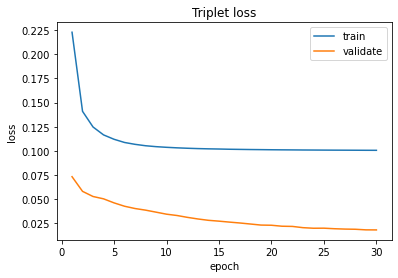

In [60]:
test_loss = []
test_iterator = []
def main():
  device = torch.device('cuda:0')
  model = EmbeddingNet()
  model.to(device)

  batch_size= p*k
  print_freq = 60
  criterion = TripletMarginLoss(margin =0.1) # hyper parameter margin can be changed
  optimizer = Adam(model.parameters(),lr=0.0001)
  for epoch in range(1,31):
    print('Training...')
    train_epoch(model,optimizer,criterion,train_dataloader,device,epoch,print_freq)
    save(model,epoch,"/content/drive/My Drive/ColabNotebooks/","lion.pt")
  
  model = EmbeddingNet()
  criterion = TripletMarginLoss(margin =0.01)
  print_freq = 30
  for epoch in range(1,31):
    print('Testing...')
    test_epoch(model,criterion,test_dataloader,device,epoch,print_freq)    
  show_plot_two(test_iterator,train_loss,test_loss,"train","validate","Triplet loss")
if __name__ == '__main__':
  main()

In [17]:
print('Evaluating . . . ')
#http://queirozf.com/entries/evaluation-metrics-for-ranking-problems-introduction-and-examples
#https://ils.unc.edu/courses/2013_spring/inls509_001/lectures/10-EvaluationMetrics.pdf
test_dataloader2 = DataLoader(test_dataset,num_workers=4,batch_size=1,shuffle=False)
model = EmbeddingNet()
model.eval()
model.to(device)
accuracy_list = []
recall1_list = []
precision1_list = []

recall2_list = []
precision2_list = []

for i in range(1,30):
  accuracy = 0
  total = 0
  true_positive = 0
  true_negative = 0
  false_positive=0
  false_negative =0

  data_iter = iter(test_dataloader2)

  img0,target0 =next(data_iter)
  img0 = img0.to(device)
  target0 = target0.to(device)
  #print(target0.item())
  model_string = "/content/drive/My Drive/ColabNotebooks/epoch_"+str(30)+"_lion.pt"
  model.load_state_dict(torch.load(model_string))
  precision_c1 = 0.0
  recall_c1 = 0.0

  precision_c2 = 0.0
  recall_c2 = 0.0
  for i,data in enumerate(test_dataloader2):
    img1,target1 =data[0].to(device),data[1].to(device)
    embed0= model(img0)
    embed1= model(img1)
    contactenated = torch.cat((img0,img1),0)
    dist =  F.pairwise_distance(embed0,embed1)
    if target1.item() == target0.item():
      
      if dist<0.002:
        true_positive+=1
        total+=1
      else:
        false_positive+=1
        total+=1
    else:
        if dist>=0.002:
          true_negative+=1
          total+=1
        else:
          false_negative+=1
          total+=1
  acc = (true_positive+true_negative)/total
  accuracy_list.append(acc)
  if true_positive !=0: 
    recall_c1 = true_positive /(true_positive+false_negative) 
    recall1_list.append(recall_c1)
    precision_c1 =true_positive/(true_positive+false_positive)
    precision1_list.append(precision_c1)
  if true_negative!=0:
    precision_c2 = true_negative/(true_negative+false_positive)
    precision2_list.append(precision_c2)
    recall_c2 = true_negative/(true_negative+false_negative)
    recall2_list.append(recall_c2)

print('Accuracy: {0:.1f}, Recall: {1:.1f} Precision: {2:.1f}'.format(mean(accuracy_list),mean(recall1_list),mean(precision1_list)))
print('Accuracy: {0:.1f}, Recall: {1:.1f} Precision: {2:.1f}'.format(mean(accuracy_list),mean(recall2_list),mean(precision2_list)))

Evaluating . . . 
Accuracy: 1.0, Recall: 1.0 Precision: 0.7
Accuracy: 1.0, Recall: 1.0 Precision: 1.0


In [0]:
def plot_dists(y_points1,y_points2,color1="blue",color2="red"):
  list_size = len(y_points1)

  plt.scatter(y_points1,y_points1,c=color1,s=5,label="same label")
  #list_size = len(y_points2)
  #x_list = np.arange(0,list_size,1)
  new_list = y_points2[:list_size]
  plt.scatter(new_list,new_list,c=color2,s=5,label ="different label")
  plt.xlabel('distances range')
  plt.ylabel('distances')

  plt.legend(loc='upper left')
  plt.show()


In [0]:
def plot_dists_all(y_points1,y_points2,color1="blue",color2="red"):

  list_size = len(y_points1)
  x_list = np.linspace(0,30,num=list_size)
  plt.scatter(x_list,y_points1,c=color1,s=5,label="same label")
  list_size = len(y_points2)
  x_list = np.linspace(0,30,num=list_size)
  plt.scatter(x_list,y_points2,c=color2,s=5,label="different label")
  #plt.xlim(0.01,0.008)
  plt.xlabel('iteration')
  plt.ylabel('distances')

  plt.legend(loc='upper left')
  plt.show()

Plotting dists . . . 


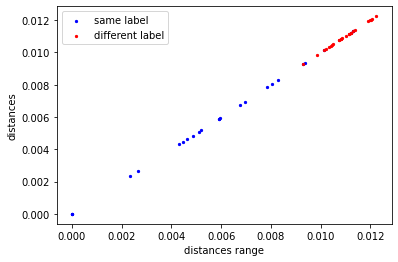

In [21]:
print('Plotting dists . . . ')
#http://queirozf.com/entries/evaluation-metrics-for-ranking-problems-introduction-and-examples
#https://ils.unc.edu/courses/2013_spring/inls509_001/lectures/10-EvaluationMetrics.pdf
test_dataloader2 = DataLoader(test_dataset,num_workers=4,batch_size=1,shuffle=False)
model = EmbeddingNet()
model.eval()
model.to(device)
model_string = "/content/drive/My Drive/ColabNotebooks/epoch_"+str(30)+"_lion.pt"
model.load_state_dict(torch.load(model_string))
accuracy_list = []
recall1_list = []
precision1_list = []

recall2_list = []
precision2_list = []

same_class_dists=[]
diff_class_dists=[]

same_class_dists_av=[]
diff_class_dists_av=[]

for i in range(1,60):  
  data_iter = iter(test_dataloader2)

  img0,target0 =next(data_iter)
  img0 = img0.to(device)
  target0 = target0.to(device)
  embed0= model(img0)
  for i,data in enumerate(test_dataloader2):
    img1,target1 =data[0].to(device),data[1].to(device)
    embed1= model(img1)
    dist =  F.pairwise_distance(embed0,embed1)
    dist_a = round(dist.item(),4)
    if target1.item() == target0.item():
      same_class_dists.append(dist_a)
      if(i %5 == 0):
        same_class_dists_av.append(np.mean(same_class_dists))
        same_class_dists = []
    else:
      diff_class_dists.append(dist_a)
      if i%5 == 0 :
        diff_class_dists_av.append(np.mean(diff_class_dists))
        diff_class_dists = []
plot_dists(same_class_dists_av,diff_class_dists_av)
  

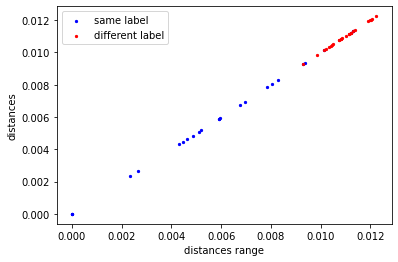

In [22]:
plot_dists(same_class_dists_av,diff_class_dists_av)

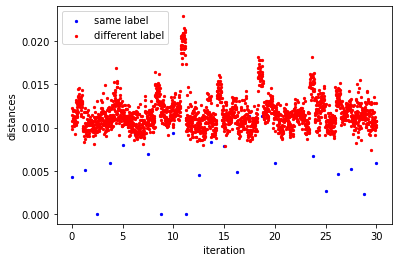

In [23]:

plot_dists_all(same_class_dists_av,diff_class_dists_av)

In [24]:
#plot_dists_all(same_class_dists_av,diff_class_dists_av)
print('Mean distance between images in same class {:.4f}'.format(np.mean(same_class_dists_av)))
print('Mean distance between images in different class {:.4f}'.format(np.mean(diff_class_dists_av)))


Mean distance between images in same class 0.0061
Mean distance between images in different class 0.0116


In [25]:
print('Evaluation  mAP . . . ')
#http://queirozf.com/entries/evaluation-metrics-for-ranking-problems-introduction-and-examples
#https://ils.unc.edu/courses/2013_spring/inls509_001/lectures/10-EvaluationMetrics.pdf
test_dataloader2 = DataLoader(test_dataset,num_workers=4,batch_size=1,shuffle=False)
model = EmbeddingNet()
model.eval()
model.to(device)
accuracy_list = []
recall1_list = []
precision1_list = []

relevant_items1 = 0
relevant_items2 = 0
recall2_list = []
precision2_list = []
model_string = "/content/drive/My Drive/ColabNotebooks/epoch_"+str(30)+"_lion.pt"
model.load_state_dict(torch.load(model_string))

mean_average_prec = []
for i in range(1,100):
  dist_class = []
  data_iter = iter(test_dataloader2)
  img0,target0 =next(data_iter)
  img0 = img0.to(device)
  target0 = target0.to(device)
  for d,data in enumerate(test_dataloader2):
    img1,target1 =data[0].to(device),data[1].to(device)
    embed0= model(img0)
    embed1= model(img1)
    #contactenated = torch.cat((img0,img1),0)
    dist =  F.pairwise_distance(embed0,embed1)
    dist_r = round(dist.item(),4)
    if target1.item() == target0.item():
      relevant_items1=relevant_items1 + 1
      t = (dist_r,0)
      dist_class.append(t)
    else:
      relevant_items2=relevant_items2+1
      t = (dist_r,1)
      dist_class.append(t)
  dist_class.sort(key = lambda x: x[0])
  true_positive_class1 = 0
  false_positive_class1 = 0
  
  true_negative_class1 = 0
  false_negative_class1 = 0
  total = 0
  predicted_positive = 0
  p = 0
  for data in dist_class:
    distance,class_ind = data[0],data[1]
    if class_ind==0:
      total= total+1
      if distance<0.002:
        true_positive_class1=true_positive_class1+1
        predicted_positive=predicted_positive+1
        p = p+(true_positive_class1/total)
  
  ap =0
  if  predicted_positive>0:
    ap= p/predicted_positive
  precision1_list.append(ap)
  if i%100 ==0:
    print('AP : {0:.4f}'.format(ap))
print('mAP {:.4f}'.format(mean(precision1_list)))

Evaluation  mAP . . . 
mAP 0.7172


In [26]:
print('mAP {:.4f}'.format(mean(precision1_list)))

mAP 0.7172
